# PPO Training Control Panel

This interactive notebook prepares PPO training for the CrazyFlie simulator. Make sure the following dependencies are available in your environment before running the live widgets:

- [MuJoCo](https://mujoco.org/) physics engine and mujoco-python bindings
- OpenCV (`cv2`) for the FPV picture-in-picture overlay controls
- [`ipywidgets`](https://ipywidgets.readthedocs.io/en/latest/) for the interactive UI
- [Stable-Baselines3](https://stable-baselines3.readthedocs.io/en/master/) with PyTorch backend (install via `stable-baselines3[extra]`)
- Matplotlib for inline plotting

Install the Python packages with for example:

```bash
pip install mujoco opencv-python ipywidgets stable-baselines3[extra] matplotlib
```

Enable the Jupyter widget extension when running in the classic notebook interface:

```bash
jupyter nbextension enable --py widgetsnbextension
```

When you finish training, run the teardown cell at the end to close the simulator, MuJoCo viewer, and any OpenCV windows.


In [1]:
# Ensure we execute from the repository root so local imports resolve correctly.
from pathlib import Path
import os
import sys

REPO_ROOT = Path.cwd().resolve()
if not (REPO_ROOT / 'train').exists():
    for parent in REPO_ROOT.parents:
        if (parent / 'train').exists() and (parent / 'crazy_flie_env').exists():
            os.chdir(parent)
            REPO_ROOT = parent
            break
else:
    os.chdir(REPO_ROOT)

if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

print(f'📁 Repository root: {REPO_ROOT}')


📁 Repository root: C:\Users\Ratan.Bunkar\Learning\general\rl-agent\Drone-UAV


In [ ]:
# Core imports for training, visualization, and widget-based controls.
import contextlib
import threading
import time
import traceback
from collections import deque
from typing import Optional, Tuple

import dataclasses

import numpy as np
import ipywidgets as widgets
from IPython.display import display

import matplotlib.pyplot as plt

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv

from train.train import TrainingConfig, TrainingManager, LiveTrainingVisualizationCallback
from crazy_flie_env.core.environment import CrazyFlieEnv
from crazy_flie_env.vision.rendering import RenderingSystem
from crazy_flie_env.utils.config import EnvConfig

MODEL_PATH = (REPO_ROOT / 'bitcraze_crazyflie_2').resolve()
if not MODEL_PATH.exists():
    raise FileNotFoundError(f'CrazyFlie MuJoCo assets not found at {MODEL_PATH}')


✅ Registered algorithm: A2C
✅ All required dependencies found!
✅ Successfully imported CrazyFlieEnv
✅ Stable Baselines3 imported successfully
🛠️ CrazyFlie model assets: C:\Users\Ratan.Bunkar\Learning\general\rl-agent\Drone-UAV\bitcraze_crazyflie_2


In [3]:
# Helper utilities: environment unwrapping, FPV window management, and live plotting callback.

def _unwrap_env(env):
    """Peel Gym/Gymnasium wrappers until we reach the base CrazyFlie environment."""
    base = env
    visited = set()
    while hasattr(base, "env") and id(base) not in visited:
        visited.add(id(base))
        base = base.env
    if hasattr(base, "unwrapped"):
        base = base.unwrapped
    return base


class PIPWindowController:
    """Widget-driven controller for the FPV OpenCV window."""

    def __init__(self, initial_position: Tuple[int, int] = (320, 180),
                 initial_size: Tuple[int, int] = (640, 480)):
        self.position = list(initial_position)
        self.window_size = list(initial_size)
        self.base_env = None
        self._lock = threading.Lock()
        self._cv2 = self._try_import_cv2()
        self._suspend_events = False
        self.ui = self._build_ui()

    def _try_import_cv2(self):
        try:
            import cv2  # type: ignore
            return cv2
        except ImportError:
            return None

    def _build_ui(self):
        move_step = widgets.IntSlider(
            value=40, min=1, max=400, step=1, description="Move Δ",
            continuous_update=False
        )
        size_step = widgets.IntSlider(
            value=60, min=10, max=600, step=5, description="Size Δ",
            continuous_update=False
        )

        self.x_slider = widgets.IntSlider(
            value=self.position[0], min=0, max=1920, step=5,
            description="Window X", continuous_update=False
        )
        self.y_slider = widgets.IntSlider(
            value=self.position[1], min=0, max=1200, step=5,
            description="Window Y", continuous_update=False
        )
        self.width_slider = widgets.IntSlider(
            value=self.window_size[0], min=160, max=1920, step=10,
            description="Width", continuous_update=False
        )
        self.height_slider = widgets.IntSlider(
            value=self.window_size[1], min=120, max=1200, step=10,
            description="Height", continuous_update=False
        )

        self.x_slider.observe(lambda change: self._on_position_change(change, axis=0), names="value")
        self.y_slider.observe(lambda change: self._on_position_change(change, axis=1), names="value")
        self.width_slider.observe(lambda change: self._on_size_change(change, axis=0), names="value")
        self.height_slider.observe(lambda change: self._on_size_change(change, axis=1), names="value")

        arrows = widgets.GridBox([
            widgets.Label(""),
            widgets.Button(description="↑", layout=widgets.Layout(width="50px")),
            widgets.Label(""),
            widgets.Button(description="←", layout=widgets.Layout(width="50px")),
            widgets.Button(description="•", layout=widgets.Layout(width="50px")),
            widgets.Button(description="→", layout=widgets.Layout(width="50px")),
            widgets.Label(""),
            widgets.Button(description="↓", layout=widgets.Layout(width="50px")),
            widgets.Label("")
        ], layout=widgets.Layout(grid_template_columns="repeat(3, 60px)", align_items="center"))

        (up_btn, left_btn, center_btn, right_btn, down_btn) = (
            arrows.children[1], arrows.children[3], arrows.children[4], arrows.children[5], arrows.children[7]
        )

        up_btn.on_click(lambda _: self.nudge(0, -move_step.value))
        down_btn.on_click(lambda _: self.nudge(0, move_step.value))
        left_btn.on_click(lambda _: self.nudge(-move_step.value, 0))
        right_btn.on_click(lambda _: self.nudge(move_step.value, 0))
        center_btn.on_click(lambda _: self.recenter())

        grow_btn = widgets.Button(description="Larger", icon="expand")
        shrink_btn = widgets.Button(description="Smaller", icon="compress")
        grow_btn.on_click(lambda _: self.resize(size_step.value, size_step.value))
        shrink_btn.on_click(lambda _: self.resize(-size_step.value, -size_step.value))

        cv_status = "✅" if self._cv2 is not None else "❌"
        cv_label = widgets.HTML(f"<b>OpenCV:</b> {cv_status}")

        return widgets.VBox([
            widgets.HTML("<h3>FPV window controls</h3>"),
            cv_label,
            widgets.HBox([self.x_slider, self.y_slider]),
            widgets.HBox([self.width_slider, self.height_slider]),
            widgets.HBox([move_step, size_step]),
            arrows,
            widgets.HBox([grow_btn, shrink_btn])
        ], layout=widgets.Layout(width="45%", border="1px solid #ccc", padding="10px"))

    def attach_env(self, env):
        with self._lock:
            self.base_env = env
        self.apply_window_changes()

    def detach_env(self):
        with self._lock:
            self.base_env = None

    def recenter(self):
        self._set_position(320, 180)

    def nudge(self, dx: int, dy: int):
        with self._lock:
            self.position[0] = max(0, self.position[0] + dx)
            self.position[1] = max(0, self.position[1] + dy)
        self._sync_sliders()
        self.apply_window_changes()

    def resize(self, dwidth: int, dheight: int):
        with self._lock:
            self.window_size[0] = max(160, self.window_size[0] + dwidth)
            self.window_size[1] = max(120, self.window_size[1] + dheight)
        self._sync_sliders()
        self.apply_window_changes()

    def _on_position_change(self, change, axis: int):
        if self._suspend_events:
            return
        with self._lock:
            self.position[axis] = int(change["new"])
        self.apply_window_changes()

    def _on_size_change(self, change, axis: int):
        if self._suspend_events:
            return
        with self._lock:
            self.window_size[axis] = int(change["new"])
        self.apply_window_changes()

    def _set_position(self, x: int, y: int):
        with self._lock:
            self.position = [max(0, int(x)), max(0, int(y))]
        self._sync_sliders()
        self.apply_window_changes()

    def _sync_sliders(self):
        self._suspend_events = True
        try:
            self.x_slider.value = self.position[0]
            self.y_slider.value = self.position[1]
            self.width_slider.value = self.window_size[0]
            self.height_slider.value = self.window_size[1]
        finally:
            self._suspend_events = False

    def apply_window_changes(self):
        renderer = self._current_renderer()
        if renderer is None or not getattr(renderer, "opencv_available", False):
            return
        try:
            cv2 = self._cv2 or self._try_import_cv2()
            if cv2 is None:
                return
            cv2.moveWindow(renderer.pip_window_name, self.position[0], self.position[1])
            cv2.resizeWindow(renderer.pip_window_name, self.window_size[0], self.window_size[1])
        except Exception:
            pass

    def update_overlay(self):
        renderer = self._current_renderer()
        env = self._current_env()
        if renderer is None or env is None:
            return
        if not getattr(renderer, "opencv_available", False):
            return
        try:
            frame = env.camera_system.get_drone_camera_image(env.physics.data)
            renderer.show_pip_overlay(frame, window_position=tuple(self.position))
            self.apply_window_changes()
        except Exception as exc:
            print(f"⚠️ Unable to refresh FPV overlay: {exc}")

    def close(self):
        renderer = self._current_renderer()
        if renderer is not None and getattr(renderer, "opencv_available", False):
            try:
                cv2 = self._cv2 or self._try_import_cv2()
                if cv2 is not None:
                    cv2.destroyWindow(renderer.pip_window_name)
            except Exception:
                pass
        self.detach_env()

    def _current_env(self):
        with self._lock:
            return self.base_env

    def _current_renderer(self):
        env = self._current_env()
        if env is None:
            return None
        return getattr(env, "renderer", None)


class NotebookTrainingVisualizationCallback(LiveTrainingVisualizationCallback):
    """Extended live visualization with episode length and success tracking."""

    def __init__(self, env, render_freq: int = 1000, success_window: int = 50,
                 pip_controller: Optional[PIPWindowController] = None, verbose: int = 0):
        super().__init__(env, render_freq=render_freq, verbose=verbose)
        self.current_episode_length = 0
        self.episode_lengths = []
        self.episode_success_flags = []
        self.success_rate_history = []
        self.success_window = max(1, int(success_window))
        self._recent_successes = deque(maxlen=self.success_window)
        self.pip_controller = pip_controller

        if hasattr(self, "fig"):
            self.fig.clf()
            self.ax_rewards = self.fig.add_subplot(1, 3, 1)
            self.ax_lengths = self.fig.add_subplot(1, 3, 2)
            self.ax_success = self.fig.add_subplot(1, 3, 3)
            for ax in (self.ax_rewards, self.ax_lengths, self.ax_success):
                ax.grid(True, alpha=0.3)
            self.fig.set_size_inches(15, 4)
            self.fig.suptitle("Live PPO Training Metrics", fontsize=14)
            self.fig.tight_layout()

    def _on_step(self) -> bool:
        if "rewards" in self.locals:
            self.current_episode_reward += self.locals["rewards"][0]
        self.current_episode_length += 1

        done = bool(self.locals.get("dones", [False])[0]) if "dones" in self.locals else False
        if done:
            info = {}
            if "infos" in self.locals and len(self.locals["infos"]) > 0:
                info = self.locals["infos"][0] or {}

            crashed = bool(info.get("is_crashed", False))
            success = not crashed

            self.episode_rewards.append(self.current_episode_reward)
            self.episode_lengths.append(self.current_episode_length)
            self.episode_success_flags.append(success)
            self._recent_successes.append(1 if success else 0)
            rolling_success = float(np.mean(self._recent_successes)) if len(self._recent_successes) > 0 else 0.0
            self.success_rate_history.append(rolling_success)

            if self.logger is not None:
                self.logger.record("rollout/episode_length", self.episode_lengths[-1])
                self.logger.record("rollout/success", float(success))
                self.logger.record("rollout/rolling_success_rate", rolling_success)

            self.current_episode_reward = 0.0
            self.current_episode_length = 0
            self.episode_count += 1

            if hasattr(self, "fig"):
                self._update_plots()

        if self.num_timesteps % max(1, self.render_freq) == 0:
            try:
                target_env = None
                if hasattr(self.env, "envs") and len(self.env.envs) > 0:
                    target_env = self.env.envs[0]
                else:
                    target_env = self.env
                base_env = _unwrap_env(target_env)
                if hasattr(base_env, "render"):
                    base_env.render()
                if self.pip_controller is not None:
                    if self.pip_controller._current_env() is None:
                        self.pip_controller.attach_env(base_env)
                    self.pip_controller.update_overlay()
            except Exception as exc:
                print(f"⚠️ Rendering issue: {exc}")

        return True

    def _update_plots(self):
        if not hasattr(self, "fig"):
            return

        self.ax_rewards.clear()
        self.ax_lengths.clear()
        self.ax_success.clear()

        if self.episode_rewards:
            self.ax_rewards.plot(self.episode_rewards, color="#1f77b4", alpha=0.8)
            if len(self.episode_rewards) >= 10:
                window = min(10, len(self.episode_rewards))
                moving_avg = np.convolve(self.episode_rewards, np.ones(window) / window, mode="valid")
                self.ax_rewards.plot(range(window - 1, len(self.episode_rewards)), moving_avg,
                                     color="#ff7f0e", linewidth=2)
        self.ax_rewards.set_title(f"Episode Reward (n={len(self.episode_rewards)})")
        self.ax_rewards.set_xlabel("Episode")
        self.ax_rewards.set_ylabel("Reward")
        self.ax_rewards.grid(True, alpha=0.3)

        if self.episode_lengths:
            self.ax_lengths.plot(self.episode_lengths, color="#2ca02c", alpha=0.8)
        self.ax_lengths.set_title("Episode Length")
        self.ax_lengths.set_xlabel("Episode")
        self.ax_lengths.set_ylabel("Steps")
        self.ax_lengths.grid(True, alpha=0.3)

        if self.success_rate_history:
            self.ax_success.plot(self.success_rate_history, color="#d62728", linewidth=2)
        self.ax_success.set_title(f"Rolling Success Rate (window={self.success_window})")
        self.ax_success.set_xlabel("Episode")
        self.ax_success.set_ylabel("Success ratio")
        self.ax_success.set_ylim(0, 1)
        self.ax_success.grid(True, alpha=0.3)

        self.fig.tight_layout()
        self.fig.canvas.draw_idle()
        plt.pause(0.01)

    def set_success_window(self, new_window: int):
        new_window = max(1, int(new_window))
        self.success_window = new_window
        existing = list(self._recent_successes)
        self._recent_successes = deque(existing[-new_window:], maxlen=new_window)

        if self.episode_success_flags:
            rolling = []
            successes = []
            for flag in self.episode_success_flags:
                successes.append(1 if flag else 0)
                window = successes[-new_window:]
                rolling.append(float(np.mean(window)))
            self.success_rate_history = rolling
        self.refresh_plots()

    def refresh_plots(self):
        if hasattr(self, "fig"):
            self._update_plots()


In [4]:
# Training controller orchestrating the background learning loop and widgets.

class PPOTrainingController:
    """Interactive PPO training manager driven by ipywidgets."""

    def __init__(self, repo_root: Path, pip_controller: PIPWindowController):
        self.repo_root = Path(repo_root)
        self.pip_controller = pip_controller

        self.training_manager: Optional[TrainingManager] = None
        self.training_config: Optional[TrainingConfig] = None
        self.model = None
        self.vec_env = None
        self.base_env = None
        self.callback: Optional[NotebookTrainingVisualizationCallback] = None

        self.stop_event = threading.Event()
        self.pause_event = threading.Event()
        self.pause_event.set()
        self.training_thread: Optional[threading.Thread] = None

        self._build_widgets()

    def _build_widgets(self):
        self.learning_rate = widgets.FloatLogSlider(
            value=3e-4, base=10, min=-6, max=-2, step=0.1,
            description="Learning rate", continuous_update=False
        )
        self.render_freq = widgets.IntSlider(
            value=500, min=1, max=5000, step=50,
            description="Render freq", continuous_update=False
        )
        self.chunk_steps = widgets.IntSlider(
            value=1024, min=128, max=4096, step=128,
            description="Chunk steps", continuous_update=False
        )
        self.total_steps = widgets.IntText(value=200_000, description="Target steps")
        self.success_window = widgets.IntSlider(
            value=50, min=5, max=200, step=5,
            description="Success window", continuous_update=False
        )

        self.start_button = widgets.Button(description="Start / Restart", icon="play", button_style="success")
        self.pause_button = widgets.Button(description="Pause", icon="pause", button_style="warning")
        self.resume_button = widgets.Button(description="Resume", icon="play")
        self.stop_button = widgets.Button(description="Stop", icon="stop", button_style="danger")
        self.status = widgets.HTML("<b>Status:</b> idle")
        self.log_output = widgets.Output(layout=widgets.Layout(border="1px solid #ccc", height="180px", overflow_y="auto"))

        self.learning_rate.observe(self._on_learning_rate_change, names="value")
        self.render_freq.observe(self._on_render_freq_change, names="value")
        self.success_window.observe(self._on_success_window_change, names="value")

        self.start_button.on_click(self.start_training)
        self.pause_button.on_click(self.pause_training)
        self.resume_button.on_click(self.resume_training)
        self.stop_button.on_click(self.stop_training)

        hyperparams = widgets.VBox([
            widgets.HTML("<h3>Training hyper-parameters</h3>"),
            self.learning_rate,
            self.render_freq,
            self.chunk_steps,
            self.total_steps,
            self.success_window
        ], layout=widgets.Layout(width="100%"))

        buttons = widgets.HBox([self.start_button, self.pause_button, self.resume_button, self.stop_button])

        left_panel = widgets.VBox([
            hyperparams,
            buttons,
            self.status,
            self.log_output
        ], layout=widgets.Layout(width="55%", border="1px solid #ccc", padding="10px"))

        self.ui = widgets.HBox([
            left_panel,
            self.pip_controller.ui
        ])

    def _log(self, message: str):
        with self.log_output:
            print(message)

    def start_training(self, _=None):
        self._log("🔄 Starting (or restarting) PPO training...")
        self.status.value = "<b>Status:</b> initializing"
        self._request_stop(join=True)
        self._close_env()
        try:
            self._configure_training()
        except Exception as exc:
            self.status.value = f"<b>Status:</b> error during setup - {exc}"
            traceback.print_exc()
            return

        self.stop_event.clear()
        self.pause_event.set()
        self.training_thread = threading.Thread(target=self._training_loop, name="ppo-training", daemon=True)
        self.training_thread.start()
        self.status.value = "<b>Status:</b> running"
        self._log("🚀 Background training loop launched.")

    def pause_training(self, _=None):
        if self.training_thread and self.training_thread.is_alive():
            self.pause_event.clear()
            self.status.value = f"<b>Status:</b> pause requested (t={getattr(self.model, 'num_timesteps', 0):,})"
            self._log("⏸️ Pause will take effect after the current chunk finishes.")
        else:
            self._log("⚠️ No active training thread to pause.")

    def resume_training(self, _=None):
        if self.training_thread and self.training_thread.is_alive():
            self.pause_event.set()
            self.status.value = "<b>Status:</b> running"
            self._log("▶️ Resuming training.")
        else:
            self._log("⚠️ Nothing to resume; start training first.")

    def stop_training(self, _=None):
        self._request_stop(join=True)
        self.status.value = "<b>Status:</b> stopped"

    def shutdown(self):
        """Public teardown helper for the notebook's cleanup cell."""
        self._request_stop(join=True)
        self._close_env()
        self.status.value = "<b>Status:</b> shutdown complete"
        self._log("🧹 Cleaned up PPO training session.")

    def _configure_training(self):
        env_config = EnvConfig(model_path=str(MODEL_PATH))

        self.training_config = TrainingConfig(
            algorithm="PPO",
            total_timesteps=int(self.total_steps.value),
            num_envs=1,
            seed=42,
            learning_rate=float(self.learning_rate.value),
            render_freq=int(self.render_freq.value),
            enable_live_training=False,
            env_config=env_config
        )

        self.training_manager = TrainingManager(self.training_config)

        base_env = CrazyFlieEnv(config=self.training_config.env_config)
        monitor_env = Monitor(base_env)
        self.vec_env = DummyVecEnv([lambda: monitor_env])
        self.base_env = base_env
        self.pip_controller.attach_env(self.base_env)

        self.callback = NotebookTrainingVisualizationCallback(
            self.vec_env,
            render_freq=self.training_config.render_freq,
            success_window=int(self.success_window.value),
            pip_controller=self.pip_controller
        )

        self.training_manager.trainer.create_model(self.vec_env)
        self.model = self.training_manager.trainer.model
        self.model.set_env(self.vec_env)

        lr_value = float(self.learning_rate.value)
        self.model.learning_rate = lr_value
        self.model.lr_schedule = lambda _: lr_value

        self.vec_env.reset()
        self._log("✅ Environment and PPO model ready.")

    def _training_loop(self):
        try:
            while not self.stop_event.is_set():
                self.pause_event.wait()
                if self.stop_event.is_set():
                    break

                chunk = int(self.chunk_steps.value)
                self.model.learn(total_timesteps=chunk, callback=self.callback, reset_num_timesteps=False)
                self.callback.refresh_plots()
                if self.pip_controller is not None:
                    self.pip_controller.update_overlay()

                target = int(self.total_steps.value)
                if target > 0 and getattr(self.model, "num_timesteps", 0) >= target:
                    self.status.value = f"<b>Status:</b> target reached ({self.model.num_timesteps:,} steps)"
                    self._log("🏁 Reached target total timesteps.")
                    break

                self.status.value = f"<b>Status:</b> running (t={self.model.num_timesteps:,})"
        except Exception as exc:
            self.status.value = f"<b>Status:</b> error during training - {exc}"
            self._log(f"❌ Training error: {exc}")
            traceback.print_exc()
        finally:
            self.training_thread = None
            self.stop_event.clear()
            self.pause_event.set()
            self._log("ℹ️ Training loop finished.")

    def _request_stop(self, join: bool = False):
        if self.training_thread and self.training_thread.is_alive():
            self.stop_event.set()
            self.pause_event.set()
            if join:
                self.training_thread.join()
            self._log("⏹️ Training loop stopped.")
        self.training_thread = None
        self.stop_event.clear()
        self.pause_event.set()

    def _close_env(self):
        if self.model is not None and hasattr(self.model, "env"):
            with contextlib.suppress(Exception):
                self.model.env.close()
        if self.vec_env is not None:
            with contextlib.suppress(Exception):
                self.vec_env.close()
        if self.base_env is not None:
            with contextlib.suppress(Exception):
                self.base_env.close()
        if self.pip_controller is not None:
            self.pip_controller.close()

        self.training_manager = None
        self.training_config = None
        self.model = None
        self.vec_env = None
        self.base_env = None
        self.callback = None

    def _on_learning_rate_change(self, change):
        new_lr = float(change["new"])
        if self.training_config is not None:
            self.training_config.learning_rate = new_lr
        if self.model is not None:
            self.model.learning_rate = new_lr
            self.model.lr_schedule = lambda _: new_lr
        self._log(f"ℹ️ Learning rate set to {new_lr}")

    def _on_render_freq_change(self, change):
        new_freq = int(change["new"])
        if self.training_config is not None:
            self.training_config.render_freq = new_freq
        if self.callback is not None:
            self.callback.render_freq = max(1, new_freq)
        self._log(f"ℹ️ Render frequency set to {new_freq}")

    def _on_success_window_change(self, change):
        new_window = int(change["new"])
        if self.callback is not None:
            self.callback.set_success_window(new_window)
        self._log(f"ℹ️ Success window updated to {new_window}")


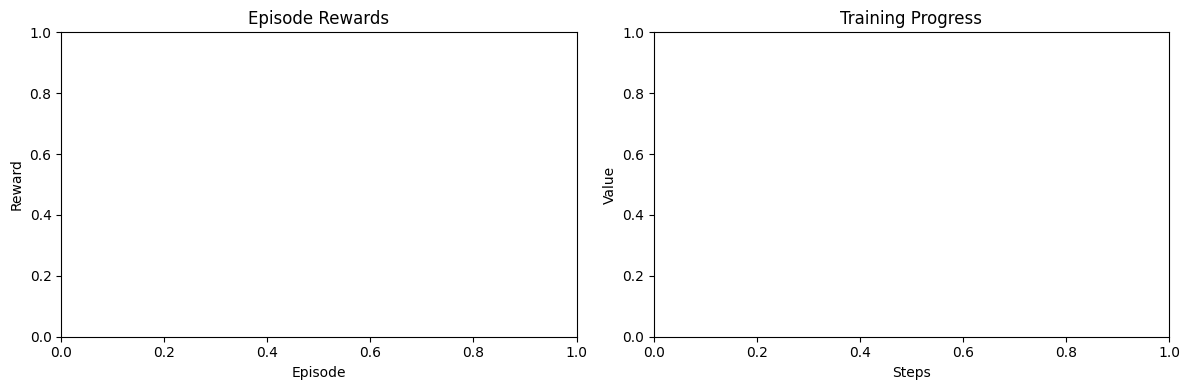

🖥️ MuJoCo viewer launched
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 53.8     |
|    ep_rew_mean          | -2.79    |
|    episode_length       | 61       |
|    rolling_success_rate | 0        |
|    success              | 0        |
| time/                   |          |
|    fps                  | 89       |
|    iterations           | 1        |
|    time_elapsed         | 11       |
|    total_timesteps      | 1024     |
--------------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 50.5     |
|    ep_rew_mean          | -3.19    |
|    episode_length       | 37       |
|    rolling_success_rate | 0        |
|    success              | 0        |
| time/                   |          |
|    fps                  | 115      |
|    iterations           | 1        |
|    time_elapsed         | 8        |
|    total_timesteps      | 2048     |

In [5]:
# Instantiate the UI components and display the interactive dashboard.
pip_controller = PIPWindowController()
training_controller = PPOTrainingController(REPO_ROOT, pip_controller)

display(widgets.VBox([
    widgets.HTML("<h2>PPO Live Training Control Center</h2>"),
    training_controller.ui
]))


In [6]:
# Teardown helper — run this cell when you are finished training.
training_controller.shutdown()


🔒 MuJoCo viewer closed
🖼️ PIP display closed
🔒 Rendering system closed
🔒 Camera system closed
🔒 Physics engine closed
🔒 Environment closed successfully
🔒 Rendering system closed
🔒 Camera system closed
🔒 Physics engine closed
🔒 Environment closed successfully
🔒 Rendering system closed
🔒 Camera system closed
🔒 Physics engine closed
🔒 Environment closed successfully
